## Modelling
It's time to build some models. These are the transformers and estimators we will be testing out.

1. Transformers
    - CountVectorizer
    - TfidfVectorizer
2. Parametric estimators
    - Logistic Regression
    - Multinomial Naive Bayes
3. Tree-based non-parametric estimators
    - Random Forest
    - Extra Trees
    - AdaBoost
    - GradientBoost

We will pair up a transformer and an estimator and gridsearch through a default set of parameters for each combined model. We'll compare the top 2 or 3 models and decide which ones we want to finetune further before finally choosing our working model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
from bs4 import BeautifulSoup

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier)
pd.options.display.html.use_mathjax = False

In [3]:
# some matplotlib params to make the defaults a bit more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Create functions for iterative modelling
Throughout this process, we may have to continually iterate over our models, finding new things to tune each time. Let's lay out some functions that help us do this.

In [3]:
# this function is from our previous notebook. we import this just in case we need to use it.

# possible regexes for tokenizer
regex1 = r'\$?[\d\.\/A-Za-z]+|\w\w+' # this dumb shit tokenizes normal words, and anything that starts with $ sign. like money.
                                     # set gaps=False.
regex2 = r'\s+', # also set gaps= True. this splits by whitespace. 

def get_wordnet_pos(word):
    """
    word is e.g. "model". pos_tag creates a list containing tuple(s) for whatever words it is passed.
    the output will be [('model', 'NN')], which indicates that model is a noun. 
    we extract the 'tag' to be used by calling output[0][1][0], which is ('model', 'NN') inside the list, and 'NN' inside
    the tuple, and 'N' inside the 'NN'. we map this to wordnet.NOUN, for e.g.
    we then return to the output of this function, the appropriate wordnet.TAG
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_preprocessor(raw_text, regex = r'\w+|[\d]+|\S+', lemma=True, sw=[]):
    """
    default tokenizer will split by whitespace. change regex to fit needs.
    this function WILL take very long to run if you allow it to lemmatize.
    default stopwords uses nltk's english stopwords. pass in a list of stopwords to sw if you want to add unique stopwords.
    """
    # remove html elements
    text = BeautifulSoup(raw_text).get_text()
    
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # remove punctuation
#     text = re.sub(r'[^a-zA-Z\d\$]',' ',text)    
    
    #convert all to lowercase and split, i.e. tokenize
    words = text.lower().split()
    
#     # convert using tokenizer
    tokenizer = RegexpTokenizer(regex)
    words = tokenizer.tokenize(text.lower())
    
    # remove stopwords
    stops = set(stopwords.words('english') + sw)
    words_nostop = [w for w in words if w not in stops ]    
    
    # allow user to choose whether to lemma data or not
    if lemma:
        # lemma each word
        # this function gets the pos_tag for each word first, then tells the lemmatizer how to lemmatize each word
        # by calling the correct pos_tag. e.g. wordnet.VERB for a verb word, wordnet.ADJ for an adjective

        lemmatizer = WordNetLemmatizer()
        words_lem = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words_nostop if w.isalnum()]
        return " ".join(words_lem)
    
    return " ".join(words_nostop)
    

In [4]:
# this function allows me to quickly create my GridSearchCV object using whatever transformers or estimators i want.

vecs = {'cvec': CountVectorizer(),
        'tvec': TfidfVectorizer()}
models = {'lr': LogisticRegression(max_iter=1000, random_state=101),
          'nb': MultinomialNB(),
          'rf': RandomForestClassifier(random_state=101),
          'et': ExtraTreesClassifier(random_state=101),
          'ada': AdaBoostClassifier(DecisionTreeClassifier(), random_state=101),
          'gb': GradientBoostingClassifier(random_state=101)
         }

def gscv_creator(vectorizer, model, pipe_params, n_jobs=-1):
    """
    helps me instantiate my models quickly. 
    pass in your choice of vectorizer and model
    ensure that your parameters for gridsearching are prefixed correctly according to the dunder__ convention 
    leave n_jobs as -1 unless you have good reason for making it slower and more painful than necessary.
    """
    pipe = Pipeline([
        (vectorizer, vecs[vectorizer]),
        (model, models[model]),
    ])
    
    gs = GridSearchCV(pipe,
                      pipe_params,
                      cv=5,
                      verbose=1,
                      n_jobs=n_jobs) # force maximum number of concurrent workers
    return gs


In [5]:
# this function prints a bunch of summary stats about our GridSearchCV object. 
# it requires that our GridSearchCV object has been fit on the training set already.

def gscv_result_printer(gs, X=None, y=None):
    """
    feed in a GridSearchCV that is already fit on X_train, y_train.
    prints out a bunch of stuff to compare
    """
    print("Best CV score: {}".format(gs.best_score_))
    print("Best params: {}".format(gs.best_params_))
    print('----------')
    predictions = gs.predict(X_train)
    print("Training ROC AUC: {}".format(roc_auc_score(y_train, predictions)))
    print("Training accuracy: {}".format(gs.score(X_train, y_train)))
    # pass in X and Y arguments if you would like to score the gs object on something else, like the X_val set.
    if X is None:
        pass
    else:
        predictions = gs.predict(X)
        print("Validation ROC AUC: {}".format(roc_auc_score(y_val, predictions)))
        print("Validation accuracy: {}".format(gs.score(X,y)))
        tn, fp, fn, tp = confusion_matrix(y_val, predictions).ravel()
        print(f'True positives: {tp}')
        print(f'False positives: {fp}')
        print(f'True negatives: {tn}')
        print(f'False negatives: {fn}')

## Model factory
Let's load in our data and start running a few different models on them. To facilitate comparisons between models, we will first run these models using some standard params, and simply compare the baseline scores we get from each model.

In [6]:
# load our data
df = pd.read_csv('./data/options_stocks_processed_combined.csv')

### Baseline score
In order to score our model's performance, we need to decide on a metric to use. 2 metrics come to mind - accuracy and f1-score. This is a rough summary of what each metric is useful for.

1. Accuracy
    - good when you have balanced classes and you are [interested in True Positives and True Negatives.](https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2#)
2. ROC AUC 
    - good when you have balanced classes and you are interested in understanding the [discriminability of your model](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)(the class probabilities that the model predicts for each observation).
    
For our project, both are appropriate, so we will want to use both. Let's check our class ratio.

In [7]:
# look at the balance of our target classes
df['subreddit'].value_counts(normalize=True)

1    0.510938
0    0.489063
Name: subreddit, dtype: float64

This is great, our classes are quite well-balanced, so we'll go ahead with scoring our models on both metrics. We will also use the proportion of our majority class as our baseline accuracy, as that is the accuracy we would obtain simply by predicting all our target observations to be the majority class.

Our baseline accuracy is thus 51.1%. Our model should aim to beat this score, otherwise there is no reason to build a model.

In [7]:
X = df['all_text_clean']
y = df['subreddit']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, random_state = 420)


### Parametric models
Let's begin scoring a few different models

In [9]:
# Model 1: CountVectorizer with Logistic Regression

pipe_params = {
    'cvec__max_df':[0.9, 0.85],
    'cvec__min_df':[2,3],
    'cvec__max_features':[2000,5000,8000],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':[['stocks','options','stock','option']],
    'lr__C':[0.5,0.7,1.0]
}
`
lr_cvec_cv = gscv_creator('cvec', 'lr', pipe_params)
lr_cvec_cv.fit(X_train, y_train)
gscv_result_printer(lr_cvec_cv, X_val, y_val)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.0min finished


Best CV score: 0.8520833333333334
Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 8000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['stocks', 'options', 'stock', 'option'], 'lr__C': 0.5}
----------
Training ROC AUC: 0.9985795454545455
Training accuracy: 0.9986111111111111
Validation ROC AUC: 0.8712114633087278
Validation accuracy: 0.8708333333333333
True positives: 209
False positives: 26
True negatives: 209
False negatives: 36


In [10]:
# Model 2: TfIDFVectorizer with Logistic Regression

pipe_params = {
    'tvec__max_df':[0.9, 0.85],
    'tvec__min_df':[2,3],
    'tvec__max_features':[2000,5000,8000],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__stop_words':[['stocks','options','stock','option']],
    'lr__C':[0.5,0.7,1.0]
}

lr_tvec_cv = gscv_creator('tvec', 'lr', pipe_params)
lr_tvec_cv.fit(X_train, y_train)
gscv_result_printer(lr_tvec_cv, X_val, y_val)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   46.9s finished


Best CV score: 0.875
Best params: {'lr__C': 1.0, 'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option', 'preview', 'redd', 'format', 'auto', 'png', 'reddit', 'http', 'https', 'www', 'com', 'amp', 'automoderator']}
----------
Training ROC AUC: 0.9442008399209485
Training accuracy: 0.94375
Validation ROC AUC: 0.8798089448545375
Validation accuracy: 0.8791666666666667
True positives: 208
False positives: 21
True negatives: 214
False negatives: 37


In [1]:
# Model 3: CountVectorizer with Multinomial Naive Bayes
pipe_params = {
    'cvec__max_df':[0.9, 0.85],
    'cvec__min_df':[2,3],
    'cvec__max_features':[2000,5000,8000],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':[['stocks','options','stock','option']],
    'nb__alpha':[0.5,1.0]
}

nb_cvec_cv = gscv_creator('cvec', 'nb', pipe_params)
nb_cvec_cv.fit(X_train, y_train)
gscv_result_printer(nb_cvec_cv, X_val, y_val)

NameError: name 'gscv_creator' is not defined

In [12]:
# Model 4: TfIDFVectorizer with Multinomial Naive Bayes

pipe_params = {
    'tvec__max_df':[0.9, 0.85],
    'tvec__min_df':[2,3],
    'tvec__max_features':[2000,5000,8000],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__stop_words':[['stocks','options','stock','option']],
    'nb__alpha':[0.5,1.0]
}

nb_tvec_cv = gscv_creator('tvec', 'nb', pipe_params)
nb_tvec_cv.fit(X_train, y_train)
gscv_result_printer(nb_tvec_cv, X_val, y_val)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   30.3s finished


Best CV score: 0.8597222222222222
Best params: {'nb__alpha': 0.5, 'tvec__max_df': 0.9, 'tvec__max_features': 8000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option', 'preview', 'redd', 'format', 'auto', 'png', 'reddit', 'http', 'https', 'www', 'com', 'amp', 'automoderator']}
----------
Training ROC AUC: 0.9416687252964427
Training accuracy: 0.9416666666666667
Validation ROC AUC: 0.8687364307425098
Validation accuracy: 0.86875
True positives: 213
False positives: 31
True negatives: 204
False negatives: 32


Here's a summary of our initial findings:

|Vectorizer|Estimator|Train accuracy|Validation accuracy|
|---|---|---|---|
|cvec|Logistic Regression|0.999|0.865|
|tvec|Logistic Regression|0.943|0.879|
|cvec|Multinomial NB|0.908|0.835|
|tvec|Multinomial NB|0.942|0.869|

Our first model was terribly overfit, achieving almost perfect accuracy on the train set, which should not be possible. The validation accuracy was also 14% lower, which is the largest drop in performance among our 5 models tested so far. The 2 Multinomial NB models had similar levels of overfitting, but the one that used tvec scored about 3% higher in accuracy. Our Logistic Regression with tvec gave us the best results in terms of both overfitting and validation accuracy, thus it is our best model so far. From these results, we are interested in exploring Model 2 and Model 4 further.
***
#### Finetuning
Let's finetune our 2 best models to see if we can improve our scores. We will just keep running different parameters with different search ranges and see what happens to our scores.

In [33]:
# Model 2: TfIDFVectorizer with Logistic Regression

pipe_params = {
    'tvec__max_df':[0.8,0.9],
    'tvec__min_df':[1,2,3],
    'tvec__max_features':[2000,3000,5000],
    'tvec__ngram_range':[(1,4),(1,3)],
    'tvec__stop_words':[['stocks','options','stock','option']],
    'lr__C':[1.0],
    'lr__penalty':['elasticnet'],
    'lr__l1_ratio': [0],
    'lr__solver': ['saga']
}

lr_tvec_cv = gscv_creator('tvec', 'lr', pipe_params)
lr_tvec_cv.fit(X_train, y_train)
gscv_result_printer(lr_tvec_cv, X_val, y_val)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.4min finished


Best CV score: 0.8756944444444447
Best params: {'lr__C': 1.0, 'lr__l1_ratio': 0, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'tvec__max_df': 0.8, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option']}
----------
Training ROC AUC: 0.9366353754940712
Training accuracy: 0.9361111111111111
Validation ROC AUC: 0.8820234476769431
Validation accuracy: 0.88125
True positives: 207
False positives: 19
True negatives: 216
False negatives: 38


In [234]:
optimal_lr_params = lr_tvec_cv.best_params_

In [37]:
# Model 4: TfidfVectorizer with Multinomial Naive Bayes
pipe_params = {
    'tvec__max_df':[0.85, 0.9, 0.95],
    'tvec__min_df':[2,3,4],
    'tvec__max_features':[5000,8000,10000],
    'tvec__ngram_range':[(1,4),(1,2),(1,3)],
    'tvec__stop_words':[['stocks','options','stock','option']],
    'nb__alpha':[1.0]
}

nb_cvec_cv = gscv_creator('tvec', 'nb', pipe_params)
nb_cvec_cv.fit(X_train, y_train)
gscv_result_printer(nb_cvec_cv, X_val, y_val)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  2.3min finished


Best CV score: 0.8666666666666668
Best params: {'nb__alpha': 1.0, 'tvec__max_df': 0.85, 'tvec__max_features': 10000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 4), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option']}
----------
Training ROC AUC: 0.9391366106719368
Training accuracy: 0.9388888888888889
Validation ROC AUC: 0.8689101172383848
Validation accuracy: 0.86875
True positives: 211
False positives: 29
True negatives: 206
False negatives: 34


After *many, many* iterations trying out different parameters, extending the search range of parameters etc, we managed to improve these scores slightly. In fact, some iterations of grid-searching ended up slightly worsening our scores, so we are going to stick with these above parameters as they are the best we have found so far in that they reduced overfitting or improved our accuracy.

#### How to intepret the feature probability from Multinomial NB

Recall that in our example, Naive Bayes theorem takes the form 
$$P(options|words) = \frac{P(w_1|options)P(w_2|options)...P(options)}{P(w_1)P(w_2)...}$$
Putting the features above into our equation, we get
$$P(options|words) = \frac{P(call|options)P(sell|options)P(price|options)P(put|options)...P(options)}{P(call)P(sell)...}$$
From sklearn's MultinomialNB we can extract the log probabilities of these features. Exponentiating them will return to us the base probabilities of each feature. This gives us for example
$$P(call|options) = 0.0126, P(put|options) = 0.00589, P(short|options) = 0.00446$$


In [67]:
# extract the probabilities out from multiNB
coef_table2 = pd.DataFrame({'feature': nb_cvec_cv.best_estimator_['cvec'].get_feature_names(),
              'coef': np.exp(nb_cvec_cv.best_estimator_['nb'].feature_log_prob_[1])}).sort_values(by='coef', ascending=False)
coef_table2.head(20)

,feature,coef
1434,call,0.012628
6360,sell,0.007924
5581,price,0.007378
5753,put,0.005886
3242,go,0.005230
3174,get,0.005021
6467,share,0.005001
6536,short,0.004464
4499,market,0.004404
7855,would,0.004335


### Tree-based models
Having tried out 2 parametric models above, let's compare their performance to the non-parametric tree-based models. We will run both RandomForestClassifier and ExtraTreesClassifier on the same defaults and analyse their results.

In [13]:
# Model 5: CountVectorizer with RandomForest
pipe_params = {
    'cvec__max_df':[0.85, 0.9],
    'cvec__min_df':[2,3],
    'cvec__max_features':[2000,5000,8000],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':[['stocks','options','stock','option']],
    'rf__n_estimators':[100,200],
    'rf__max_depth':[None,3,5],
    'rf__min_samples_leaf':[2,5]
}

rf_cvec_cv = gscv_creator('cvec', 'rf', pipe_params)
rf_cvec_cv.fit(X_train, y_train)
gscv_result_printer(rf_cvec_cv, X_val, y_val)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.1min finished


Best CV score: 0.867361111111111
Best params: {'cvec__max_df': 0.85, 'cvec__max_features': 2000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['stocks', 'options', 'stock', 'option', 'preview', 'redd', 'format', 'auto', 'png', 'reddit', 'http', 'https', 'www', 'com', 'amp', 'automoderator'], 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 200}
----------
Training ROC AUC: 0.9832633399209486
Training accuracy: 0.9833333333333333
Validation ROC AUC: 0.8587928788536693
Validation accuracy: 0.8583333333333333
True positives: 205
False positives: 28
True negatives: 207
False negatives: 40


In [14]:
# Model 6: TfidfVectorizer with RandomForest
pipe_params = {
    'tvec__max_df':[0.85, 0.9],
    'tvec__min_df':[2,3],
    'tvec__max_features':[2000,5000,8000],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__stop_words':[['stocks','options','stock','option']],
    'rf__n_estimators':[100,200],
    'rf__max_depth':[None,3,5],
    'rf__min_samples_leaf':[2,5]
}

rf_tvec_cv = gscv_creator('tvec', 'rf', pipe_params)
rf_tvec_cv.fit(X_train, y_train)
gscv_result_printer(rf_tvec_cv, X_val, y_val)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.4min finished


Best CV score: 0.8694444444444445
Best params: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 200, 'tvec__max_df': 0.85, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option', 'preview', 'redd', 'format', 'auto', 'png', 'reddit', 'http', 'https', 'www', 'com', 'amp', 'automoderator']}
----------
Training ROC AUC: 0.992959486166008
Training accuracy: 0.9930555555555556
Validation ROC AUC: 0.8588797221016065
Validation accuracy: 0.8583333333333333
True positives: 204
False positives: 27
True negatives: 208
False negatives: 41


In [15]:
# Model 7: CountVectorizer with ExtraTrees
pipe_params = {
    'cvec__max_df':[0.85, 0.9],
    'cvec__min_df':[2,3],
    'cvec__max_features':[2000,5000,8000],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':[['stocks','options','stock','option']],
    'et__n_estimators':[100,200],
    'et__max_depth':[None,3,5],
    'et__min_samples_leaf':[2,5]
}

et_cvec_cv = gscv_creator('cvec', 'et', pipe_params)
et_cvec_cv.fit(X_train, y_train)
gscv_result_printer(et_cvec_cv, X_val, y_val)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.0min finished


Best CV score: 0.8569444444444445
Best params: {'cvec__max_df': 0.85, 'cvec__max_features': 2000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['stocks', 'options', 'stock', 'option', 'preview', 'redd', 'format', 'auto', 'png', 'reddit', 'http', 'https', 'www', 'com', 'amp', 'automoderator'], 'et__max_depth': None, 'et__min_samples_leaf': 2, 'et__n_estimators': 200}
----------
Training ROC AUC: 0.9971590909090908
Training accuracy: 0.9972222222222222
Validation ROC AUC: 0.8400781589231437
Validation accuracy: 0.8395833333333333
True positives: 200
False positives: 32
True negatives: 203
False negatives: 45


In [77]:
# Model 8: TfidfVectorizer with ExtraTrees
pipe_params = {
    'tvec__max_df':[0.85, 0.8, 0.9],
    'tvec__min_df':[1,2,3],
    'tvec__max_features':[2000,5000,8000],
    'tvec__ngram_range':[(1,2),(1,3),(1,4)],
    'tvec__stop_words':[['stocks','options','stock','option']],
    'et__n_estimators':[300,200],
    'et__max_depth':[None,3],
    'et__min_samples_leaf':[2,4]
}

et_tvec_cv = gscv_creator('tvec', 'et', pipe_params)
et_tvec_cv.fit(X_train, y_train)
gscv_result_printer(et_tvec_cv, X_val, y_val)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 27.5min finished


Best CV score: 0.8701388888888889
Best params: {'et__max_depth': None, 'et__min_samples_leaf': 2, 'et__n_estimators': 200, 'tvec__max_df': 0.85, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option', 'preview', 'redd', 'format', 'auto', 'png', 'reddit', 'http', 'https', 'www', 'com', 'amp', 'automoderator']}
----------
Training ROC AUC: 0.9978693181818181
Training accuracy: 0.9979166666666667
Validation ROC AUC: 0.8695180199739471
Validation accuracy: 0.86875
True positives: 204
False positives: 22
True negatives: 213
False negatives: 41


All our tree-based models show a high degree of overfitting. Model 8, our ExtraTreesClassifier with tvec, gave us highest validation accuracy, although not by much, so we tried again to iterate over Model 8 with different parameters, but it did not produce any better results. Model 8 can be considered to be our 'best' tree model, so we'll keep it for now to compare against our Logistic Regression and MultinomialNB models later.

#### Boosted trees
Are RandomForests the best tree-based models we can use? Let's try out AdaBoost and GradientBoost classifiers. Based on our earlier results, we will use the same TfidfVectorizer from Model 6 in conjunction with our 2 boosted tree models.

In [76]:
# Model 9: TfidfVectorizer with AdaBoost
pipe_params = {
    'tvec__max_df':[0.85, 0.9],
    'tvec__min_df':[2,3],
    'tvec__max_features':[2000,5000,8000],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__stop_words':[['stocks','options','stock','option']],
    'ada__n_estimators':[200,300],
    'ada__base_estimator__max_depth':[1,2],
    'ada__learning_rate':[0.9,0.5]
}

ada_tvec_cv = gscv_creator('tvec', 'ada', pipe_params)
ada_tvec_cv.fit(X_train, y_train)
gscv_result_printer(ada_tvec_cv, X_val, y_val)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 16.7min finished


Best CV score: 0.8354166666666666
Best params: {'ada__base_estimator__max_depth': 1, 'ada__learning_rate': 0.9, 'ada__n_estimators': 300, 'tvec__max_df': 0.85, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option']}
----------
Training ROC AUC: 1.0
Training accuracy: 1.0
Validation ROC AUC: 0.814980460269214
Validation accuracy: 0.8145833333333333
True positives: 195
False positives: 39
True negatives: 196
False negatives: 50


In [75]:
# Model 10: TfidfVectorizer with GradientBoost
pipe_params = {
    'tvec__max_df':[0.85, 0.9],
    'tvec__min_df':[2,3],
    'tvec__max_features':[2000,5000,8000],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__stop_words':[['stocks','options','stock','option']],
    'gb__n_estimators':[200,300],
    'gb__max_depth':[1,2],
    'gb__learning_rate':[0.9,0.5]
}

gb_tvec_cv = gscv_creator('tvec', 'gb', pipe_params)
gb_tvec_cv.fit(X_train, y_train)
gscv_result_printer(gb_tvec_cv, X_val, y_val)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 13.2min finished


Best CV score: 0.8493055555555555
Best params: {'gb__learning_rate': 0.5, 'gb__max_depth': 2, 'gb__n_estimators': 300, 'tvec__max_df': 0.85, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option']}
----------
Training ROC AUC: 1.0
Training accuracy: 1.0
Validation ROC AUC: 0.8635692574902302
Validation accuracy: 0.8625
True positives: 199
False positives: 20
True negatives: 215
False negatives: 46


Both our boosted models gave us very overfit scores and accuracies not much better than our other tree models. We'll disregard the use of these models and focus on Model 8 as our best tree model.

## Evaluation of models
To recap, we explored 2 different vectorizers and 6 different estimators - 2 parametric models, 2 tree-based non-parametric models, and 2 more boosted tree models. For all except the boosted tree models, we ran a model on each combination of vectorizer and estimator, and compared the results of each type of estimator within its own class. For boosted tree models, we ran them with TfidfVectorizer. Below are the results from the best performing model in each class so far, minus the boosted tree models.

|Vectorizer|Estimator|Train accuracy|Validation accuracy|Train ROCAUC|Validation ROCAUC|
|---|---|---|---|---|---|
|tvec|Logistic Regression|0.936|0.881|0.937|0.882
|tvec|Multinomial NB|0.939|0.869|0.939|0.869
|tvec|ExtraTreesClassifier|0.998|0.869|0.998|0.87

We found that all 3 models, using the TfidVectorizer gave us the least overfitting for our set of data. Comparing these 3 models together, it is clear that the LogisticRegression model with TfidfVectorizer produces by far the best result. It is the least overfit model, and it produces the highest validation accuracy. Hence, we will use this model as our classifier. Let's analyse the results returned to us by this model.

In [184]:
# Final Model: TfIDFVectorizer with Logistic Regression
# we get these optimal parameters from our previous iteration
# we remove the parameters related to elasticnet penalty as our gridsearching showed that default l2 was best.
# we technically don't need to use gridsearchcv for this, but since we already have a convenience function prepared,
# we can use the output as our optimal estimator directly

pipe_params = {
    'tvec__max_df':[0.8],
    'tvec__min_df':[2],
    'tvec__max_features':[3000],
    'tvec__ngram_range':[(1,3)],
    'tvec__stop_words':[['stocks','options','stock','option']],

    'lr__solver': ['saga']
}

lr_tvec_cv = gscv_creator('tvec', 'lr', pipe_params)
lr_tvec_cv.fit(X_train, y_train)
gscv_result_printer(lr_tvec_cv, X_val, y_val)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Best CV score: 0.8756944444444447
Best params: {'lr__solver': 'saga', 'tvec__max_df': 0.8, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option']}
----------
Training ROC AUC: 0.9366353754940712
Training accuracy: 0.9361111111111111
Validation ROC AUC: 0.8820234476769431
Validation accuracy: 0.88125
True positives: 207
False positives: 19
True negatives: 216
False negatives: 38


These are the final parameters used for our optimal Logistic Regression + TfidfVectorizer model, as well as the metrics it returns us. ROC AUC and accuracy scores are extremely close, as is expected due to our balanced classes, and our model only overfits by about 5%, which is very respectable, while still returning a validation accuracy of 88%. We should be quite satisfied with this model.

In [172]:
# we can extract the estimator direct from the gridsearchcv object.
best_lr = lr_tvec_cv.best_estimator_

### Interpretation of model results
Let's take a look at what our model thought were the most important features for predicting each class. When we extract the coefficients for each feature from LogisticRegression, what we are getting back are the coefficients for the log odds of success for the positive class. Below is the formula used in logistic regression.
$$\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

For each increase in $X_1$, the log odds of something belonging to the positive class increases by the value of the coefficient. To make this understandable, we exponentiate our coefficients first, and then we know that our odds of success increases by $e^{\beta_1}$ times for each increase in $X_1$.

But what about the odds of something belonging to the negative class? Since we are interested in knowing what words are more likely to signal r/options and also which are more likely to signal r/stocks, we also want to interpret the coefficients in terms of the negative class. A simple example would be, if something causes the positive class to be 10 times more likely, it must cause the negative class to be 10 times *less* likely. In other words, the odds of the positive class being true are **inversely related** to the odds of the negative class being true. To obtain the odds of the negative class being true, we can simply take the inverse of the coefficients returned to us by logistic regression.

In [182]:
# table of odds for r/options
success_odds_class_1 = pd.DataFrame({'feature': best_lr['tvec'].get_feature_names(),
                            'coef': np.exp(best_lr['lr'].coef_[0])}).sort_values(by='coef',ascending=False)
success_odds_class_1.head(20)

,feature,coef
466,call,215.863672
2151,put,13.094195
1552,leap,12.638701
1484,iv,8.411254
2592,strike,8.325168
2061,premium,6.966094
2586,strategy,6.717063
2537,spread,4.725990
712,cover call,4.453375
672,contract,3.974648


Interpretation of coefficients:

For a unit increase in the feature `call`, the odds of a post belonging to r/options increases by 223.6 times.

For a unit increase in the feature `put`, the odds of a post belonging to r/options increases by 13.2 times.

And so on.

In [181]:
# table of odds for r/stocks
success_odds_class_0 = pd.DataFrame({'feature': best_lr['tvec'].get_feature_names(),
                            'coef': (np.exp(best_lr['lr'].coef_[0]))**-1})\
                            .sort_values(by='coef',ascending=False)
success_odds_class_0.head(20)

,feature,coef
1469,invest,16.133699
615,company,13.958948
1683,market,6.110098
1472,investor,5.855013
2982,year,5.789708
1986,people,5.168291
1835,news,3.465679
984,etf,3.212920
44,2020,2.703129
2287,revenue,2.664311


Interpretation of coefficients:

For a unit increase in the feature `invest`, the odds of a post belonging to r/stocks increases by 15.9 times.

For a unit increase in the feature `company`, the odds of a post belonging to r/stocks increases by 13.8 times.

And so on.
***
Let's visualize these coefficients.

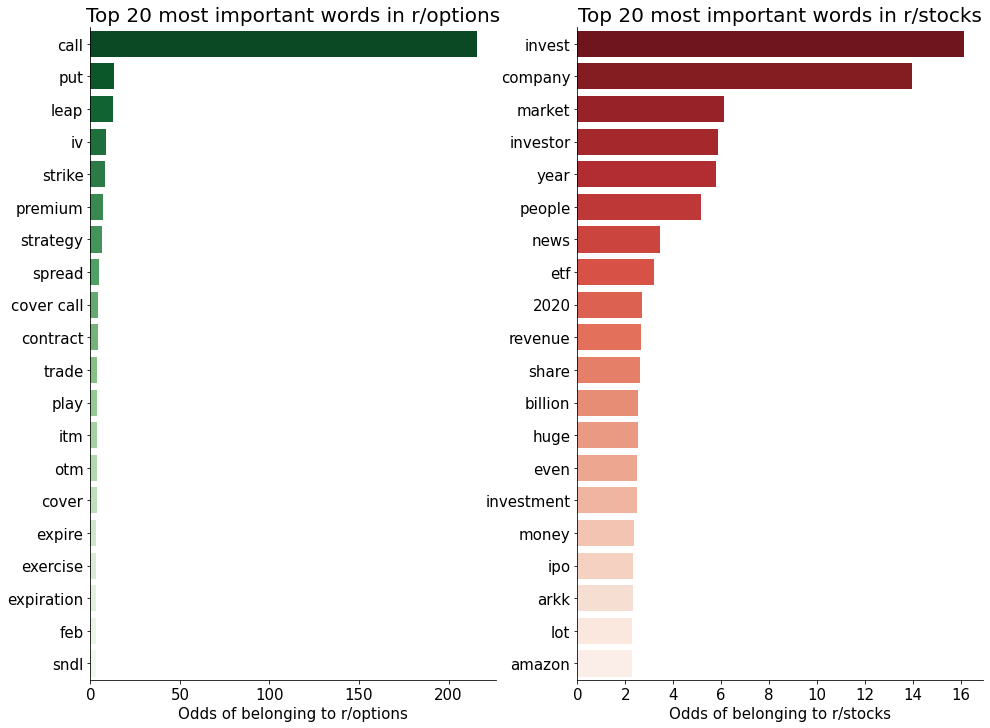

In [175]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,12))

# create graph for r/options top features
g = sns.barplot(data = success_odds_class_1.head(20), x='coef', y='feature', ax=ax1, palette = 'Greens_r')
g.set_title('Top 20 most important words in r/options',fontsize=20)
g.set_xlabel('Odds of belonging to r/options'), g.set_ylabel('')
g.tick_params(axis='both', labelsize=15)

# create graph for r/stocks top features
h = sns.barplot(data = success_odds_class_0.head(20), x='coef', y='feature', palette = 'Reds_r')
h.set_title('Top 20 most important words in r/stocks',fontsize=20)
h.set_xlabel('Odds of belonging to r/stocks'), h.set_ylabel('')
h.tick_params(axis='both', labelsize=15);

The graph above shows the most important features for each subreddit. The word `call` has a notably outsized importance when used to predict r/options. While we are not surprised that `call` is an important feature, its magnitude is a bit perplexing. It should be noted that even though the best n-gram range chosen by GridSearch was (1,3), the most important features are almost all 1-grams.

### Analysis of important features 
Similar to what we saw in our EDA, option trading specific terms have strong power in predicting what posts come from r/options. This supports our earlier thesis that option traders are very technical in their trading style, preferring to focus on option specific strategies in their discussions. As well, there is evidence of heavy use of jargon. This is shown by the fact that terms like `iv`, `premium`, `cover call` and such are in the top 20 terms. These are concepts that are very specific to options trading, indicating that option traders talk about distinctly different concepts and trends than stock traders. This could be happening even if both traders happen to be trading on Apple securities, for example.

For r/stocks, we see that features such as `invest`, `company`, `market` are important in predicting posts that come from r/stocks. These suggest that stock traders as a whole prefer to engage in more high-level, fundamental discussion, rather than using specific technical terms to discuss their trading ideas. One observation we can make is that stock traders are more interested in a certain class of stocks called Exchange Traded Funds, or ETFs, as can be seen from the feature `etf` and `arkk` which is the name of one of the most popular ETFs on the market now. These funds provide an investor a way to gain exposure to a larger basket of companies by just investing in that ETF, and are a popular vehicle among stock traders more so than option traders. We also see `ipo` listed here, which makes sense, as Initial Public Offerings are purely a means for a company begin offering their stock to the public on an exchange. You can't trade options on stocks that don't yet exist on public float.

One thing I was hoping to see more of were names of specific companies. Knowing what companies or securities are currently trending in a particular social media space is incredibly useful information for anyone trying to make an informed trading decision, as retail sentiment can be a powerful tool in forecasting price and volume movements. There are even hedge funds now that run sentiment analysis on social media threads in order to stay ahead of retail traders. If we were able to identify whether certain companies were currently more popular among stocks vs options traders, that would add another layer of usefulness to our classifier. We will explore this later on in our [recommendations](#Conclusions-and-recommendations).

## Further discussion
### False Positives and False Negatives
To better understand the shortcomings of our classifier, we should examine our False Positives and Negatives. A confusion matrix visually represents the counts of our True Positives/Negatives and False Positives/Negatives.

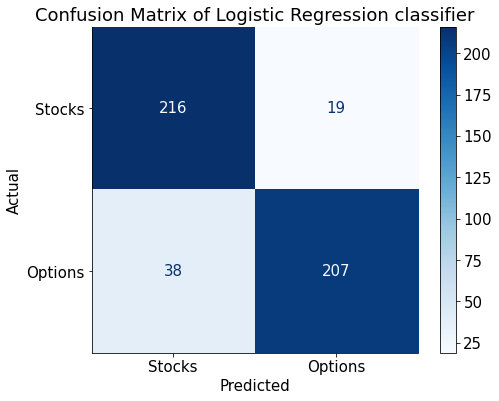

In [137]:
plot_confusion_matrix(best_lr, X_val, y_val, cmap='Blues', values_format='d')
plt.xlabel('Predicted'), plt.xticks((0,1),labels=['Stocks','Options'])
plt.ylabel('Actual'), plt.yticks((0,1),labels=['Stocks','Options'])
plt.title('Confusion Matrix of Logistic Regression classifier');

By plotting this confusion matrix, we are able to observe that we have more false negatives than positives. We are falsely predicting a post to be from r/stocks when it actually is from r/options, at almost twice the rate that we falsely predict the opposite. This begs the question, "why is our classifier worse at classifying r/options posts as opposed to r/stocks posts?"

To answer that, let's look at this diagram below.

![!](./images/options_stocks_venn.png)

This diagram shows some concepts representative of either stock trading, option trading, or both. Here we are trying to portray options as an offshoot of stocks. This is because options are a financial derivative of stocks. They came from stocks, and as such they inherit many real constructs and concepts from stocks, such price movement and trading volume. At the same time, they have also developed their own unique set of concepts, such as the idea of moneyness, which is what OTM (Out of the Money) and ITM (In the Money) refer to. This idea is unique to options, as it represents the value of an option, which is divorced from the actual value of the underlying stock. So there is a disconnect between certain unique options concepts and other concepts that have a place in both options and stock trading. This means that when a post contains features representing these concepts, like as we saw earlier when examining feature importance, features like `call` make it >200 times more likely that the post containing that feature belongs to r/options. Looking back at the table of odds above, the top features from r/options all have odds above 3, whereas for those from r/stocks, more than half of them have odds below 3. In other words, the top features from r/options are **more predictive** of r/options than the top features from r/stocks are of r/stocks. 

Therefore, when a post contains any of these uniquely options-centric features, it is easy for our classifier to know that they come from r/options. The problem, as we will see below in our misclassified posts, is when these posts no longer bear any of these distinct features. When this happens we can see that our classifier quite *severely* misclassifies these r/options posts as belonging to r/stocks. The top 3 false negatives were predicted by our classifier to have more than 80% chance to come from r/stocks. In contrast when our classifier misclassifies r/stocks posts as belonging to r/options, the predicted probability is a much more moderate 60-65%.

### Examining our misclassified posts
Our next step should then be to examine the posts that our classifier failed to classify correctly. Since we are able to extract the predicted class probabilities for each observation from our model, we can look at the most severely misclassified posts to examine what it is about these posts that confused our model.

Let's first examine our false negatives. These are posts that were predicted to be from r/stocks, but were actually from r/options. This is what our model is not so good at.

In [78]:
best_lr.fit(X_train,y_train)
predictions = best_lr.predict(X_val)

In [79]:
# extracts the predicted probabilities for each class, for each given observation
class_0, class_1 = list(zip(*best_lr.predict_proba(X_val)))
preds_df = pd.DataFrame({'actually_options': y_val,
              'predicted_options': predictions,
              'p_is_stocks': class_0,
              'p_is_options': class_1})

In [80]:
# top 5 false negatives, i.e. actually options but predicted to be stocks
preds_df[(preds_df['actually_options']==1) & (preds_df['predicted_options']==0)].sort_values(by='p_is_stocks',
                                                                                             ascending=False).head()

,actually_options,predicted_options,p_is_stocks,p_is_options
253,1,0,0.891329,0.108671
161,1,0,0.883211,0.116789
118,1,0,0.825933,0.174067
92,1,0,0.784184,0.215816
544,1,0,0.767706,0.232294


We can now look up the text for our top 5 misclassified posts using the index.

In [87]:
# printing all these posts at once takes up a lot of space
# please run the below 2 cells to use lazy evaluation to print out 1 post at a time
def lazy_post():
    for post in df.loc[[253,161,118,92,544], 'all_text']:
        yield post
post = lazy_post()

In [92]:
# run this cell to lazily print out 1 post at a time
next(post)

"Do you stay away from companies that make a profit ? I see uber, lyft, mgm etc skyrocketing.\n\nCompanies like pepsi, ebay, Sony, etc dropping hard\n\nAre we in a market where old companies are no longer interesting 🤔 \n\nPeople are buying into uber.  Assuming they don't make a profit or declare a dividend ever, does anyone really care?"

Our most misclassified post is a long one, but essentially, the poster is presenting his due diligence on a company called Lucid. It contains information on key management personnel at the company, previous stock actions, his background research on the company as well as his thesis. This is a comprehensively written post that importantly, does not mention anything related to option trading at all, which led to our classifier severely underestimating the likelihood that this post was from r/options. 

In fact, looking posts 2-4, we see that they also engage in a great amount of fundamental analysis. The 4th one actually says "for your option strategies", but as option is our stopword, this got filtered out. These posts are generally referred to as due diligence, which as we saw above, is where a person lays out a particular investment thesis on a sector or company, along with fundamental and/or technical analysis to back up his thesis. The purposes of such posts are to engender discussion among other traders to either reaffirm a particular thesis or to provide new perspectives. In general, such posts are more representative of r/stocks, as we already know that r/stocks engages in more fundamental analysis that r/options. The 5th post is a short one asking for people's opinion on an observation he had made, without mentioning anything specific regarding option trading. Because it lacked predictors for r/options, but contained words such as profit, companies, dividend, this post does indeed sound like something that belongs to r/stocks. 

In short, these 5 posts we see are not explicitly options-centric, and contain content that is characteristically more similar to that found in r/stocks than r/options. We can thus see why our classifier was confused about these posts.
***
Now let's look at our false positives. These are posts predicted to be from r/options, but were actually from r/stocks. 

In [93]:
preds_df[(preds_df['actually_options']==0) & (preds_df['predicted_options']==1)].sort_values(by='p_is_options',
                                                                                             ascending=False).head(5)

,actually_options,predicted_options,p_is_stocks,p_is_options
1704,0,1,0.325793,0.674207
1341,0,1,0.378494,0.621506
1412,0,1,0.380833,0.619167
1595,0,1,0.404049,0.595951
1039,0,1,0.417147,0.582853


From here we can look up the text from the index.

In [117]:
# printing all these posts at once is very long-winded.
# please run the cell below this one to use lazy evaluation to print out 1 post at a time
def lazy_post():
    for post in df.loc[[1704,1341,1412,1595,1039], 'all_text']:
        yield post
post = lazy_post()

In [121]:
# run this cell to lazily print out 1 post at a time
next(post)

"HUYA Available float vs short Hear me out\n\n* 97.5% of shares owned by institutional money (Tencent, MS and RenTech) - not actively trading\n* Only 2.5% trading daily\n* 30% of total float sold short.\n\nDisclaimer: I'm long. 179 shares @$32.\n\nEdit: Forgot to mention this is all possible since yesterday when MS and RenTech disclosed massive new positions."

The 1st post is a short one asking for advice. Because it doesn't specifically mention a particular type of trading, it sounds so generic that it would easily fit in either subreddit. It con was a stocks watchlist, but since we removed stocks as a stopword, it appears that our classifier did not have much else to go on, as the majority of the post is about the statistics of each stock. To be fair, a watchlist like this could very well have belonged on r/options too, so we can't fault our classifier too much.

The 2nd post we look at was literally talking about options but yet was posted to r/stocks. This is clearly a case of someone misdirecting their post to the wrong sub. They would have been better off asking this in r/options instead. This shows that our classifier could also be used to detecting when posts are posted to the wrong subreddit.

The 3rd post talks a lot about volatility. Volatility is actually a concept used more commonly in options trading, as the pricing of options is heavily influenced by two concepts - real volatility and implied volatility. Thus, reading this post on my own, I myself would probably have thought this came from r/options.

The 4th and 5th post are short ones which do sound like they come from r/stocks. However, because 'stocks' is one of our stopwords which we removed, perhaps the remaining features remaining were insufficient for our classifier to discriminate. However, we do note that they contain a number of features that are more predictive of r/options posts, such as `short`, `put`, `trade`, and `premium`. Let's take a look at the coefficients for these features.

In [124]:
success_odds_class_1[(success_odds_class_1['feature'].isin(['put','premium','short','trade']))]

,feature,coef
2143,put,13.213927
2055,premium,6.911008
2756,trade,3.970452
2427,short,2.829905


These words have quite large impact on the odds of a post belonging to r/options, hence we can understand why they may have been enough to slightly outweigh other features that are predictive of r/stocks. In fact, 3 of these features are our top 20 features for r/options. However, we should also note that our classifier was quite unsure of this decision, as the predicted probabilities for these 2 posts are below 60%, indicating that these posts contain a great deal of ambiguity.
***
In summary, our wrongly classified posts from r/options looked very much posts from r/stocks, whereas wrongly classified posts from r/stocks were either just posted to the wrong sub, or contained too much ambiguity due to the balance of certain features.

### Improving our model
Now that we've identified possible reasons why our classifier is not performing as well on r/options posts, let's see if we can improve it. If we payed close attention to the probability tables above, we would have noticed that when our classifier misclassifies r/options posts, it **really** misclassifies them. The classifier was **more than 80%** confident that these top 3 misclassified r/options posts belonged to r/stocks. In contrast, when our classifier misclassified r/stocks posts, it was **at most 67%** sure for the worst 3 examples.

Below shows the severe misclassification of our False Negatives.

In [125]:
preds_df[(preds_df['actually_options']==1) & (preds_df['predicted_options']==0)].sort_values(by='p_is_stocks',
                                                                                             ascending=False).head(3)

,actually_options,predicted_options,p_is_stocks,p_is_options
253,1,0,0.891329,0.108671
161,1,0,0.883211,0.116789
118,1,0,0.825933,0.174067


And this here shows the more moderate misclassification of r/stocks posts. While our classifier did get these wrong, observe how it was less sure of its decision as compared to above.

In [126]:
preds_df[(preds_df['actually_options']==0) & (preds_df['predicted_options']==1)].sort_values(by='p_is_options',
                                                                                             ascending=False).head(3)

,actually_options,predicted_options,p_is_stocks,p_is_options
1704,0,1,0.325793,0.674207
1341,0,1,0.378494,0.621506
1412,0,1,0.380833,0.619167


Another way to look at the uncertainty inherent in our model is to plot a histogram of the predicted probabilities. Below are the predicted probabilities of each observation that they belong to r/options. The yellow bars represent actual posts from r/stocks, and the blue those from r/options. Any yellow bar to the right of our classifier threshold are False Negatives. They are posts from r/stocks that were misclassified as r/options because their probabilities were above 0.5. Any blue bars to the left of our classifier threshold are False Positives. They are posts from r/options that were misclassified as r/stocks because their probabilities were below 0.5.

We can see clearly here that the extent of misclassification of our false negatives was much less severe than that of our false positives. Our true r/options predicted probabilities extend very far into r/stocks territory, but not vice versa. This is another way we can see that our classifier is worse at predicting r/options posts than r/stocks posts.

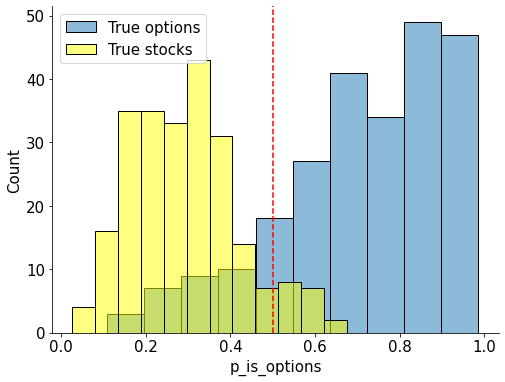

In [127]:
# plot histogram for the class probabilities for true r/options posts
sns.histplot(data=preds_df[preds_df['actually_options']==1], x='p_is_options', alpha=0.5, label ='True options')
# plot histogram for the class probabilities for true r/stocks posts
sns.histplot(data=preds_df[preds_df['actually_options']==0], x='p_is_options', alpha=0.5, color='yellow', label='True stocks')
plt.axvline(0.5, linestyle='dashed', c='red')
plt.legend();

Knowing all this now, is there a way we can improve the overall performance of our model? 

One possible method that comes to mind is to simply change our classifier threshold. We know that our classifier does worse with r/options posts, so what if we try to make it more *tolerant* for posts it is unsure of? In other words, we can try to *make* it predict more r/options posts by lowering our classification threshold from its default 0.5. Let's test a threshold range of 0.45-0.55 just to observe the general impact changing our classifier threshold has on model performance. In order for our model accuracy to increase, we are hoping that any increase in our False Negatives will be accompanied by a larger decrease in our False Positives.

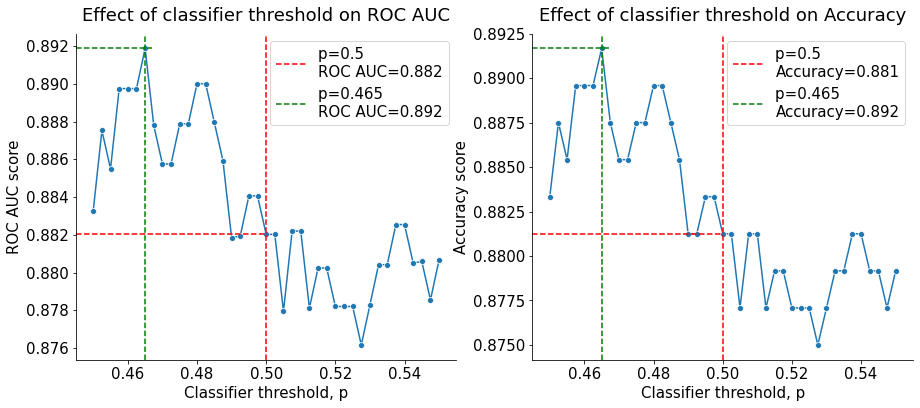

In [198]:
# create a dictionary to loop over each metric
metrics = {'ROC AUC': roc_auc_score,
           'Accuracy': accuracy_score}
fig, ax = plt.subplots(1,2, figsize=(15,6))

# create a graph for each metric
for n, (name, metric) in enumerate(metrics.items()):
    metric_array = []
    
    # test threshold range from 0.45 to 0.55 in 0.0025 increments
    for p in np.linspace(0.45,0.55,41):
        # create a set of predictions for each threshold
        preds = (preds_df['p_is_options'] > p).astype(int) 
        # calculate the metric's score of each set of predictions
        metric_score = metric(y_val, preds)
        # save these scores to an array for plotting
        metric_array.append(metric_score)
        
    # plot thresholds against scores
    sns.lineplot(x=np.linspace(0.45,0.55,41), y=metric_array, marker='o',ax=ax[n])
    # default threshold is 0.5, the middle value of our range
    # draw lines from our default point to  x and y axis
    ax[n].axhline(metric_array[20], xmax=0.5, linestyle = 'dashed', c='r')
    ax[n].axvline(0.5, linestyle = 'dashed', c='r', label = 'p=0.5 \n{}={:.3f}'.format(name, metric_array[20]))
    # find the new threshold that gives us back the highest metric score
    # do this by extracting the index of the highest metric score using np.where
    new_p = np.linspace(0.45,0.55,41)[np.where(metric_array==max(metric_array))][0]
    # plots new lines showing the new threshold and metric score
    ax[n].axvline(new_p, linestyle = 'dashed', c='g', label='p={} \n{}={:.3f}'.format(new_p,name, max(metric_array)))
    ax[n].axhline(max(metric_array), xmax=(new_p-0.445)/0.1, linestyle='dashed', c='g')
    ax[n].set_xlabel('Classifier threshold, p'), ax[n].set_ylabel('{} score'.format(name))
    ax[n].set_title('Effect of classifier threshold on {}'.format(name), y=1.02)
    ax[n].legend();

As can be seen above, playing around with our classifier threshold gave us a 1% boost in accuracy and ROC AUC when p=0.465. We can see the our new False Positives and Negatives below.

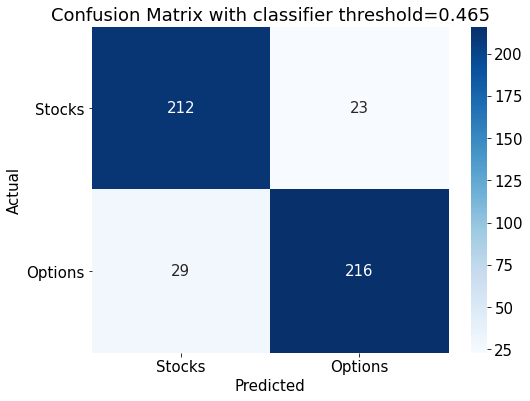

In [139]:
# create a confusion matrix for when p=0.4975.
sns.heatmap(confusion_matrix(y_val, (preds_df['p_is_options']>0.465).astype(int)), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'), plt.xticks((0.5,1.5),labels=['Stocks','Options'])
plt.ylabel('Actual'), plt.yticks((0.5,1.5),labels=['Stocks','Options'], rotation=0)
plt.title('Confusion Matrix with classifier threshold=0.465');

In [136]:
# print out our new scores when p=0.4975 for both train and val sets
train_preds = best_lr.predict(X_train)
val_preds = (preds_df['p_is_options'] > 0.465).astype(int)
metrics = {'ROC AUC': roc_auc_score,
           'Accuracy': accuracy_score}
print('For threshold p=0.465 \n----------')
for name, metric in metrics.items():
    print('Train {}: {:.5f}'.format(name, metric(y_train, train_preds)))
    print('Validation {}: {:.5f}'.format(name, metric(y_val, val_preds)))
    

For threshold p=0.4975 
----------
Train ROC AUC: 0.93664
Validation ROC AUC: 0.89188
Train Accuracy: 0.93611
Validation Accuracy: 0.89167


This table compares the results of our model with the 2 different thresholds on both the train and validation sets.

|Threshold p value|Train Accuracy|Validation Accuracy|Train ROC AUC|Validation ROC AUC
|---|---|---|---|---|
|0.5| 0.93611|0.88125|0.93663|0.88202|
|0.465|0.93611|0.89167|0.93664|0.89188|

As we saw, we managed to eke out a small improvement of 1%, while also making our False Positives and Negatives more balanced. Let's try another method of improving our model.

Another way we can adjust our model is to remove certain features were present in our misclassified posts. Let's rerun our model after adding 'short','put', and 'premium' into our stop words. These were 3 features we identified earlier when examining our misclassified posts. By removing these words, we force the model to learn new odds for each feature.

In [145]:
pipe_params = {
    'tvec__max_df':[0.8],
    'tvec__min_df':[2],
    'tvec__max_features':[3000],
    'tvec__ngram_range':[(1,3)],
    'tvec__stop_words':[['stocks','options','stock','option','put','short','premium']],

    'lr__solver': ['saga']
}

new_lr = gscv_creator('tvec', 'lr', pipe_params)
new_lr.fit(X_train, y_train)
gscv_result_printer(new_lr, X_val, y_val)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Best CV score: 0.8715277777777777
Best params: {'lr__solver': 'saga', 'tvec__max_df': 0.8, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': ['stocks', 'options', 'stock', 'option', 'put', 'short', 'premium']}
----------
Training ROC AUC: 0.9364500988142292
Training accuracy: 0.9361111111111111
Validation ROC AUC: 0.8901867129830656
Validation accuracy: 0.8895833333333333
True positives: 211
False positives: 19
True negatives: 216
False negatives: 34


Our accuracy increased from 88.2% to 89% when we add in these stop words. This is not a bad improvement in fact, and is likely to be a more generalizable way to improve our model than changing its classification threshold to 0.465, which may simply be the optimal value for *this* set of data. As such, we'll now call this new model, with the extra stopwords, our final production model.

## Conclusions and recommendations
A summary of our findings and discussion is as follows:

1. The best model for classifying our subreddit posts uses the TfidfVectorizer and Logistic Regression estimator.
2. Top predictive terms for r/options include many technical terms unique to options trading. 
    - examples include `OTM`, `ITM`, `iv`, `strike`.
    - discussions less focused on specific companies and fundamentals, more on strategies like covered calls. (`cover call` is a top feature)
3. Top predictive terms for r/options include terms related to fundamentals of companies 
    - examples include `invest`, `company`, `revenue`.
4. Our model has more trouble classifying r/options posts, and tends to severely misclassify them (lower class probabilities) as compared to r/stocks posts.

We were also able to increase our model's performance by adding in 3 new stop words, `short`, `put`, and `premium`. 

This project aimed to discover the most representative features of each subreddit that would allow us to accurately classify posts from these subreddits. We were able to do so with 89% accuracy, and even managed to tease out trends for each subreddit. Nonetheless, there is always room for improvement, and ways to make our classifier more useful.

Our first recommendation to users wishing to improve on our model would be to continually train it on a larger corpus of text. Our data was gathered from the top 1000 post from each subreddit in a month. One could feasibly scrape a new set of 1000 posts every month from each subreddit, adding to the amount of training data available for our model to learn from. This will hopefully allow our model to learn how to identify especially those r/options posts that read like r/stocks posts.

Our second recommendation to users wishing to take our model one step further would be to explore the use of named entity recognition through libraries such as spaCy. The use of named entity recognition could allow one to focus on identifying trending companies within a subreddit as a means of gauging retail sentiment. This is of incredible use to anyone who is keen on using retail sentiment to forecast price movements and trading volume. In addition, if one is able to extend named entity recognition to identify unique stock/option trading strategy names, one would be able to get a sense of popular, well-used strategies. This could be of use to a beginning investor who would like to know what strategies many people are using, so that he can focus on learning them. 

One way our classifier can already begin to accomplish this gauging of sentiment is to examine which companies are more likely to appear in a specific subreddit. We do this by looking at the odds of success (i.e. odds of belonging to a subreddit) for whatever company we are interested in.

As an example, let's look at GME, Apple, Amazon, Sundial, SPY, AMC, Blackberry, and Tilray. I picked these simply because I myself have been interested in them before, so I want to put myself in the shoes of a trader who's going to use this classifier.

In [199]:
success_odds_class_1[success_odds_class_1['feature'].isin(['blackberry','amzn','aapl','gme','amc','tlry','sndl','spy'])]

,feature,coef
2487,sndl,3.141989
2541,spy,2.697026
205,amc,2.006220
2743,tlry,1.192155
214,amzn,0.947815
119,aapl,0.686456
375,blackberry,0.526761
1235,gme,0.526120


Each mention of the company makes it x times more likely that the post comes from r/options, where x is the value of the coefficient. For companies whose coefficient is above 1, i.e. Sundial, SPY, AMC, and Tilray, this means that they are more likely to be discussed in r/options than r/stocks. The opposite is true for companies with coefficient less than 1. Amazon, Apple, Blackberry, and GME and all *less* likely to be discussed in r/options, and *more* likely to be discussed in r/stocks. 

Our very basic classifier is thus already able to gauge, albeit very loosely, the popularity of these companies within a certain class of traders. A further step would be to use sentiment analysis packages like Vader to judge whether the discussion surrounding these companies is positive or negative.